## Loading the packages

In [1]:
import os
import numpy as np

import utils.ImagesProcessor as ip
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import itertools

import models.CAE as cae

slicesSize = np.array([28, 28, 3])
overlap = 10
ratioTrainTest = 0.8
inputShape = np.array([300, 300, 3])

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading the datasets

In [2]:
def loadImages(directory_name):
    directory = os.fsencode(directory_name)
    imgs = []
    filenames = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.lower().endswith(".jpg"): 
            img = IP.readImage(directory_name + "/" + filename)
            img = IP.resizeImage(img, inputShape[:-1])
            img = IP.extractChromaticity(img)
            img_slices = IP.sliceImage(img,(slicesSize[0], slicesSize[1]),overlap)
            imgs.append(img_slices)
            filenames.append(filename)
    return np.array(imgs), filenames

In [3]:
TRAINING_PATH = "dataset_train"
NORMAL_PATH = "dataset_normal"
ANOMALY_PATH = "dataset_anomaly"
IP = ip.ImagesProcessor()

# Load the images
X_train, trainFilenames = loadImages(TRAINING_PATH)
X_normal, normalFilenames= loadImages(NORMAL_PATH)
X_anomaly, anomalyFilenames = loadImages(ANOMALY_PATH)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


In [4]:
# Normalize them
X_train = X_train.astype('float32')/255.0
X_normal = X_normal.astype('float32')/255.0
X_anomaly = X_anomaly.astype('float32')/255.0

print(X_train.shape)
#print(X_train)
print(X_normal.shape)
#print(X_normal)
print(X_anomaly.shape)
#print(X_anomaly)
#print(X)

(7, 289, 28, 28, 3)
(12, 289, 28, 28, 3)
(14, 289, 28, 28, 3)


In [15]:
def euclidienne_distance(data1, data2):    
    return np.sum(np.power(np.array(data1) - np.array(data2), 2))


def get_neighbors(training_set, 
          data_point, 
          k, 
          distance=euclidienne_distance):
    #print(data_point.shape)
    #print(training_set.shape)
    distances = []
    for indexTrain in range(len(training_set)):
        dist = distance(data_point, training_set[indexTrain])
        distances.append(dist)
    distances.sort()
    neighbors = distances[:k]
    mean_distance = np.sum(neighbors)
    return mean_distance

In [6]:
euclidienne_distance([1,2,3], [1,2,3])

0

## Explore  parameters

In [7]:
def testKNN():
    x_temp = np.random.permutation(X_train.reshape(-1, slicesSize))
    x_train = x_temp[:int(ratioTrainTest*len(X_train))]
    x_test = x_temp[int(ratioTrainTest*len(X_train)):]
    autoencoder = cae.CAE(inputShape,nbNeuronsLayers=[16, 8, 8], nbConvFilters=(3,3), poolScale=(2, 2))
    autoencoder.createModel()
    autoencoder.train(x_train, x_test, epochs=300, batch_size=64)
    
    pred_ref = autoencoder.extractFeatures(X_train.reshape(-1, slicesSize))
    print("ref:", pred_ref)
    #print(trainFilenames)
    pred_nor = autoencoder.extractFeatures(X_normal)
    print("normal:", pred_nor)
    #print(normalFilenames)
    pred_ano = autoencoder.extractFeatures(X_anomaly)
    print("anomalies:", pred_ano)
    #print(anomalyFilenames)
    return accuracy_score(np.append(pred_nor, pred_ano), [1]*len(pred_nor) + [-1]*len(pred_ano))
#print(testCAE())

In [8]:
'''
nbNeuronsLayer1 = [128, 64, 32, 16, 8]
nbNeuronsLayer2 = [128, 64, 32, 16, 8]

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

# Make data.
nbNeuronsLayer1, nbNeuronsLayer2 = np.meshgrid(nbNeuronsLayer1, nbNeuronsLayer2)

accurencies = np.array([testCAE(x,y) for x,y in zip(np.ravel(nbNeuronsLayer1), np.ravel(nbNeuronsLayer2))])
accurencies = accurencies.reshape(nbNeuronsLayer2.shape)

graph = ax.plot_surface(nbNeuronsLayer1, nbNeuronsLayer2, accurencies, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('nbNeuronsLayer1')
ax.set_ylabel('nbNeuronsLayer2 Parameter')
ax.set_zlabel('Accuracy')

# Customize the z axis.
ax.set_zlim(0, 1.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(graph, shrink=0.5, aspect=5)

plt.show()
'''

"\nnbNeuronsLayer1 = [128, 64, 32, 16, 8]\nnbNeuronsLayer2 = [128, 64, 32, 16, 8]\n\nfig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')\nax = fig.gca(projection='3d')\n\n# Make data.\nnbNeuronsLayer1, nbNeuronsLayer2 = np.meshgrid(nbNeuronsLayer1, nbNeuronsLayer2)\n\naccurencies = np.array([testCAE(x,y) for x,y in zip(np.ravel(nbNeuronsLayer1), np.ravel(nbNeuronsLayer2))])\naccurencies = accurencies.reshape(nbNeuronsLayer2.shape)\n\ngraph = ax.plot_surface(nbNeuronsLayer1, nbNeuronsLayer2, accurencies, cmap=cm.coolwarm,\n                       linewidth=0, antialiased=False)\n\nax.set_xlabel('nbNeuronsLayer1')\nax.set_ylabel('nbNeuronsLayer2 Parameter')\nax.set_zlabel('Accuracy')\n\n# Customize the z axis.\nax.set_zlim(0, 1.00)\nax.zaxis.set_major_locator(LinearLocator(10))\nax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))\n\n# Add a color bar which maps values to colors.\nfig.colorbar(graph, shrink=0.5, aspect=5)\n\nplt.show()\n"

## Final Model

In [9]:
x_temp = X_train.reshape(-1, slicesSize[0], slicesSize[1], slicesSize[2])
x_temp = np.random.permutation(x_temp)
x_train = x_temp[:int(ratioTrainTest*len(X_train))]
x_test = x_temp[int(ratioTrainTest*len(X_train)):]
autoencoder = cae.CAE(slicesSize,nbNeuronsLayers=[16, 8, 8], nbConvFilters=(3,3), poolScale=(2, 2))
autoencoder.createModel()
autoencoder.train(x_train, x_test, epochs=300, batch_size=64)

Instructions for updating:
Use the retry module or similar alternatives.
Train on 5 samples, validate on 2018 samples
Epoch 1/300
5/5 [==============================] - 1s 140ms/step - loss: 0.0349 - val_loss: 0.0340
Epoch 2/300
5/5 [==============================] - 1s 101ms/step - loss: 0.0340 - val_loss: 0.0333
Epoch 3/300
5/5 [==============================] - 0s 97ms/step - loss: 0.0334 - val_loss: 0.0329
Epoch 4/300
5/5 [==============================] - 0s 96ms/step - loss: 0.0329 - val_loss: 0.0325
Epoch 5/300
5/5 [==============================] - 0s 95ms/step - loss: 0.0326 - val_loss: 0.0323
Epoch 6/300
5/5 [==============================] - 1s 102ms/step - loss: 0.0323 - val_loss: 0.0320
Epoch 7/300
5/5 [==============================] - 0s 100ms/step - loss: 0.0320 - val_loss: 0.0316
Epoch 8/300
5/5 [==============================] - 1s 100ms/step - loss: 0.0317 - val_loss: 0.0313
Epoch 9/300
5/5 [==============================] - 1s 100ms/step - loss: 0.0313 - val_loss: 0

In [18]:
X_train_features = []
for img in X_train:
    X_train_features.append(autoencoder.extractFeatures(img))
X_train_features = np.array(X_train_features)
print(X_train_features.shape)

X_normal_features = []
for img in X_normal:
    X_normal_features.append(autoencoder.extractFeatures(img))
X_normal_features = np.array(X_normal_features)
print(X_normal_features.shape)

X_anomaly_features = []
for img in X_anomaly:
    X_anomaly_features.append(autoencoder.extractFeatures(img))
X_anomaly_features = np.array(X_anomaly_features)
print(X_anomaly_features.shape)

train_distances = []
for img_index in range(X_train_features.shape[0]):
    slices_distances = []
    for slice_img in X_train_features[img_index]:
        slices_distances.append(get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, 5))
    train_distances.append(np.mean(slices_distances))
    #print(trainFilenames[img_index], " - mean : ", np.mean(slices_distances))

deltaError = np.percentile(train_distances, 75)
print("deltaError=", deltaError)

test_distances = []
for img_index in range(X_normal_features.shape[0]):
    slices_distances = []
    for slice_img in X_normal_features[img_index]:
        slices_distances.append(get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, 4))
    mean = np.mean(slices_distances)
    if mean < deltaError:
        classe = 1
    else:
        classe = -1
    print(normalFilenames[img_index], " - classe : ", classe)
    test_distances.append(classe)
    
for img_index in range(X_anomaly_features.shape[0]):
    slices_distances = []
    for slice_img in X_anomaly_features[img_index]:
        slices_distances.append(get_neighbors(X_train_features.reshape(-1, X_train_features.shape[2], X_train_features.shape[3], X_train_features.shape[4]), slice_img, 4))
    mean = np.mean(slices_distances)
    if mean < deltaError:
        classe = 1
    else:
        classe = -1
    test_distances.append(classe)
    print(anomalyFilenames[img_index], " - classe : ", classe)
    
    

(7, 289, 4, 4, 8)
(12, 289, 4, 4, 8)
(14, 289, 4, 4, 8)
deltaError= 0.011968583799898624
NA_0209.jpg  - classe :  1
NA_0247.jpg  - classe :  -1
NA_0244.jpg  - classe :  1
NA_0268.jpg  - classe :  1
NA_0240.jpg  - classe :  -1
NA_0267.jpg  - classe :  1
NA_0266.jpg  - classe :  1
NA_0261.jpg  - classe :  -1
NA_0212.jpg  - classe :  1
NA_0216.jpg  - classe :  1
NA_0203.jpg  - classe :  1
NA_0200.jpg  - classe :  1
A_0254.jpg  - classe :  -1
A_0255.jpg  - classe :  -1
A_0241.jpg  - classe :  -1
A_0257.jpg  - classe :  -1
A_0242.jpg  - classe :  -1
A_0256.jpg  - classe :  -1
A_0253.jpg  - classe :  -1
A_0251.jpg  - classe :  -1
A_0236.jpg  - classe :  -1
A_0205.jpg  - classe :  1
A_0249.jpg  - classe :  -1
A_0248.jpg  - classe :  -1
A_0258.jpg  - classe :  -1
A_0259.jpg  - classe :  -1


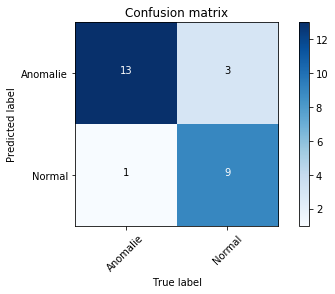

In [19]:
conf_mat = confusion_matrix(test_distances, [1]*len(X_normal_features) + [-1]*len(X_anomaly_features))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):     
    labels_names_ref = ["Anomalie", "Normal"]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels_names_ref))
    plt.xticks(tick_marks, labels_names_ref, rotation=45)
    plt.yticks(tick_marks, labels_names_ref)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
plot_confusion_matrix(conf_mat)

In [21]:
print("Accuracy:", accuracy_score(test_distances, [1]*len(X_normal_features) + [-1]*len(X_anomaly_features)))
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)

Accuracy: 0.8461538461538461
Precision:  0.8392857142857143
Recall:  0.85625
F1-Score:  0.84768299104792
